# Plots for logistic regression, different noise levels and overparameterization ratios for consistent AT

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import dotenv
import pandas as pd
import mlflow
import plotly
import plotly.graph_objects as go
import plotly.express as px,,
import plotly.subplots
import plotly.io as pio

import typing
import os
import shutil
import sys
import warnings

In [2]:
EXPORT = False
SHOW_TITLES = not EXPORT
EXPERIMENT_NAME = 'logistic_regression_noise_levels'

In [3]:
# Load environment variables
dotenv.load_dotenv()

# Enable loading of the project module
MODULE_DIR = os.path.join(os.path.abspath(os.path.join(os.path.curdir, os.path.pardir, os.pardir)), 'src')
sys.path.append(MODULE_DIR)

In [4]:
%load_ext autoreload
%autoreload 2
import interpolation_robustness as ir

In [5]:
FIGURE_SIZE = (2.6, 2.0)
LEGEND_FONT_SIZE = ir.plots.FONT_SIZE_SMALL_PT

ir.plots.setup_matplotlib(show_titles=SHOW_TITLES)

In [6]:
if EXPORT:
    EXPORT_DIR = os.path.join(ir.util.REPO_ROOT_DIR, 'logs', f'export_{EXPERIMENT_NAME}')
    print('Using export directory', EXPORT_DIR)
    if os.path.exists(EXPORT_DIR):
        shutil.rmtree(EXPORT_DIR)
    os.makedirs(EXPORT_DIR)

def export_fig(fig: plt.Figure, filename: str):
    # If export is disabled then do nothing
    if EXPORT:
        export_path = os.path.join(EXPORT_DIR, filename)
        fig.savefig(export_path)
        print('Exported figure at', export_path)


## Load experiment data

In [7]:
client = mlflow.tracking.MlflowClient()
experiment = client.get_experiment_by_name(EXPERIMENT_NAME)
runs = mlflow.search_runs(
    experiment.experiment_id
)
runs = runs.set_index('run_id', drop=False)  # set index, but keep column to not break stuff depending on it

# Convert some parameters to numbers and sort accordingly
runs['params.data_dim'] = runs['params.data_dim'].astype(int)
runs['params.train_attack_epsilon'] = runs['params.train_attack_epsilon'].astype(np.float)
runs['params.test_attack_epsilon'] = runs['params.test_attack_epsilon'].astype(np.float)
runs['params.l2_lambda'] = runs['params.l2_lambda'].astype(np.float)
runs['params.label_noise'] = runs['params.label_noise'].astype(np.float)
runs = runs.sort_values(['params.label_noise', 'params.data_dim'])
print('Loaded', len(runs), 'runs')
assert runs['status'].eq('FINISHED').all()

Loaded 4560 runs


In [8]:
grouping_keys = ['params.data_dim', 'params.l2_lambda', 'params.label_noise']
aggregate_metrics = ('metrics.true_robust_risk', 'metrics.training_loss')
runs_agg = runs.groupby(grouping_keys, as_index=False).aggregate({metric: ['mean', 'std'] for metric in aggregate_metrics})

## Plots

In [9]:
noiseless_color_idx = 3
noisy_color_idx = 5
unregularized_linestyle_idx = 0
regularized_linestyle_idx = 1

In [10]:
data_dims = runs['params.data_dim'].unique()
num_samples, = runs['params.data_num_train_samples'].astype(int).unique()
no_noise, label_noise = np.sort(runs['params.label_noise'].unique())

assert no_noise == 0
print('Label noise in the noisy case:', label_noise)

BASELINE_LAMBDA = 0.0

Label noise in the noisy case: 0.1


In [11]:
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

noreg_runs = runs_agg[runs_agg['params.l2_lambda'] == BASELINE_LAMBDA]
bestreg_runs = runs_agg.sort_values(('metrics.true_robust_risk', 'mean')).groupby(['params.data_dim', 'params.label_noise'], as_index=False).first()

noreg_noiseless_runs = noreg_runs[noreg_runs['params.label_noise'] == no_noise]
noreg_noisy_runs = noreg_runs[noreg_runs['params.label_noise'] != no_noise]

bestreg_noiseless_runs = bestreg_runs[bestreg_runs['params.label_noise'] == no_noise]
bestreg_noisy_runs = bestreg_runs[bestreg_runs['params.label_noise'] != no_noise]

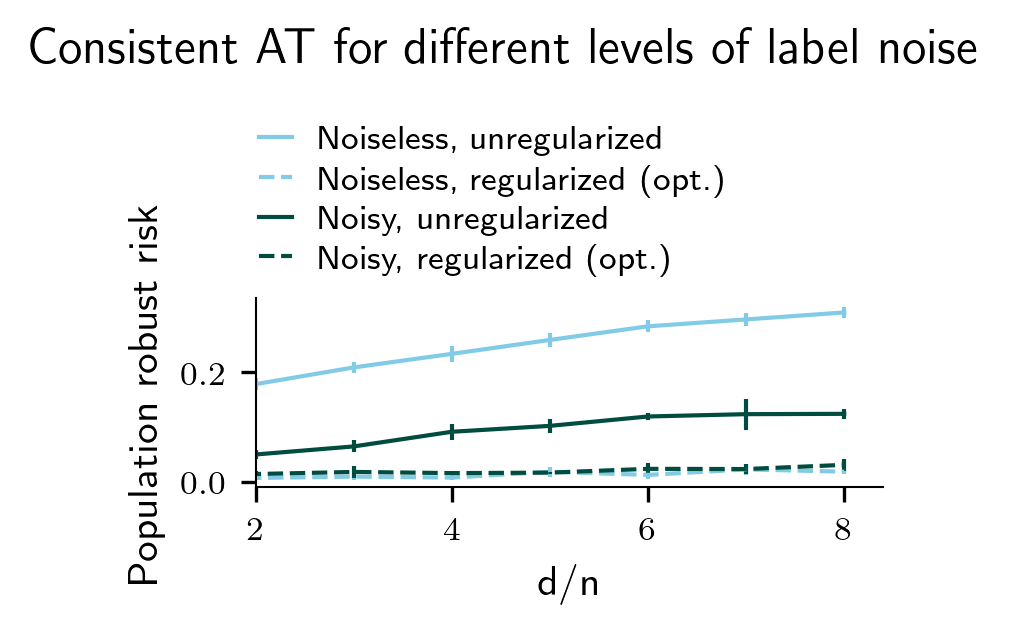

In [12]:
fig, ax = plt.subplots(figsize=FIGURE_SIZE)

ax.errorbar(
    noreg_noiseless_runs['params.data_dim'] / float(num_samples),
    noreg_noiseless_runs[('metrics.true_robust_risk', 'mean')],
    yerr=noreg_noiseless_runs[('metrics.true_robust_risk', 'std')],
    label=fr'Noiseless, unregularized',
    ls=ir.plots.LINESTYLE_MAP[unregularized_linestyle_idx],
    c=f'C{noiseless_color_idx}'
)
ax.errorbar(
    bestreg_noiseless_runs['params.data_dim'] / float(num_samples),
    bestreg_noiseless_runs[('metrics.true_robust_risk', 'mean')],
    yerr=bestreg_noiseless_runs[('metrics.true_robust_risk', 'std')],
    label=fr'Noiseless, regularized (opt.)',
    ls=ir.plots.LINESTYLE_MAP[regularized_linestyle_idx],
    c=f'C{noiseless_color_idx}'
)
ax.errorbar(
    noreg_noisy_runs['params.data_dim'] / float(num_samples),
    noreg_noisy_runs[('metrics.true_robust_risk', 'mean')],
    yerr=noreg_noisy_runs[('metrics.true_robust_risk', 'std')],
    label=fr'Noisy, unregularized',
    ls=ir.plots.LINESTYLE_MAP[unregularized_linestyle_idx],
    c=f'C{noisy_color_idx}'
)
ax.errorbar(
    bestreg_noisy_runs['params.data_dim'] / float(num_samples),
    bestreg_noisy_runs[('metrics.true_robust_risk', 'mean')],
    yerr=bestreg_noisy_runs[('metrics.true_robust_risk', 'std')],
    label=fr'Noisy, regularized (opt.)',
    ls=ir.plots.LINESTYLE_MAP[regularized_linestyle_idx],
    c=f'C{noisy_color_idx}'
)
ax.set_xlabel('d/n')
ax.set_xlim(left=2.0)
ax.set_ylim(bottom=-0.01)
ax.set_ylabel('Population robust risk')

if SHOW_TITLES:
    fig.suptitle(f'Consistent AT for different levels of label noise')

legend_loc = (0.0, 1.1)
ir.plots.errorbar_legend(ax, fontsize=LEGEND_FONT_SIZE, loc=legend_loc)

export_fig(fig, f'logreg_noise_levels.pdf')
